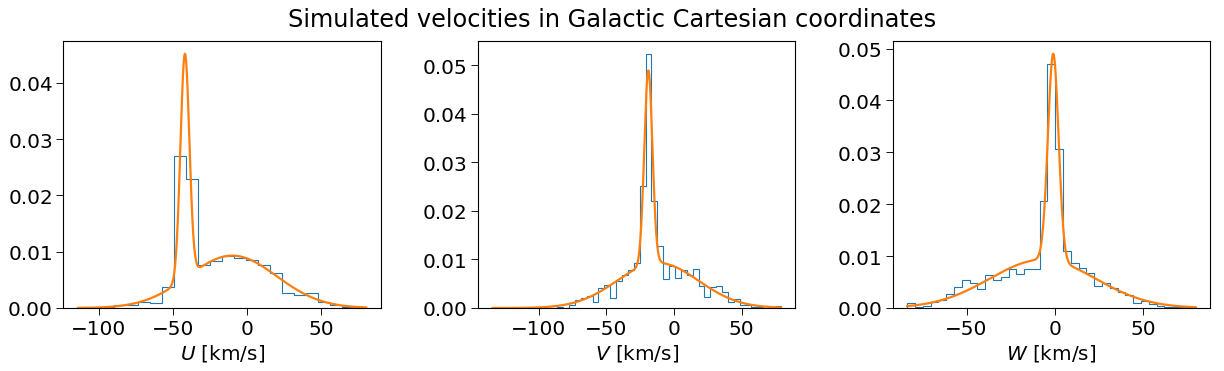

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from extreme_deconvolution.extreme_deconvolution import extreme_deconvolution as xd
from scipy.stats import norm, multinomial, uniform, multivariate_normal
from scipy.linalg import inv

from pygaia.astrometry.vectorastrometry import phaseSpaceToAstrometry, sphericalToCartesian, normalTriad
from pygaia.astrometry.coordinates import CoordinateTransformation, Transformations
from pygaia.astrometry import constants

rc('font', family='sans', size=18)
rc('xtick.major', size='6')
rc('xtick.minor', size='4')
rc('ytick.major', size='6')
rc('ytick.minor', size='4')
rc('lines', linewidth=2.0)
rc('axes', linewidth=1)
rc('xtick', direction='out')
rc('ytick', direction='out')
rc('grid', color='cbcbcb')
rc('grid', linestyle='-')
rc('grid', linewidth=0.5)
rc('grid', alpha=1.0)
rc('figure', facecolor='ffffff')
rc('figure', dpi=80)
rc('figure.subplot', bottom=0.125)

# Simulate a collection of stars distributed at constant space density around the sun, 
# with distances between 1 and 500 pc. Use Galactic coordinates. Each star is assigned
# a 3D space velocity drawn from a superposition of several 3D normal distributions in 
# velocity space.
rmin = 1.0
rmax = 500.0
Nstars = 1000
r = np.power(rmin**3 + uniform.rvs(size=Nstars)*(rmax**3-rmin**3), 1.0/3.0)
galon = uniform.rvs(size=Nstars)*np.pi*2
galat = np.arccos(uniform.rvs(size=Nstars)*2-1)-np.pi/2

x_gal, y_gal, z_gal = sphericalToCartesian(r, galon, galat)

# Define the space velocities (u,v,w), again in galactic coordinates
ncomponents = 2
means_componentA = np.array([-10, -12, -7])
means_componentB = np.array([-42,-19,-1])
covars_componentA = np.array([[900, 0, 0], [0, 900, 0], [0, 0, 900]])
covars_componentB = np.array([[9, 0, 0], [0, 9, 0], [0, 0, 9]])

means_true = np.array([means_componentA, means_componentB])
covars_true = np.array([covars_componentA, covars_componentB])
amps_true = [0.7, 0.3]
assign_to_component = multinomial.rvs(1,amps_true,size=Nstars)

uvw_gal = np.zeros((Nstars,3))
for kk in range(ncomponents):
    uvw_gal[assign_to_component[:,kk]==1,:] = \
    multivariate_normal.rvs(size=np.sum(assign_to_component[:,kk]==1), mean=means_true[kk], cov=covars_true[kk])
    
fig = plt.figure(figsize=(16,5))
axA = fig.add_subplot(1,3,1)
axA.hist(uvw_gal[:,0], bins='auto', histtype='step', normed=True)
x = np.linspace(uvw_gal[:,0].min(), uvw_gal[:,0].max(), 1000)
axA.plot(x, amps_true[0]*norm.pdf(x, loc=means_componentA[0], scale=np.sqrt(covars_componentA[0,0])) +
        amps_true[1]*norm.pdf(x, loc=means_componentB[0], scale=np.sqrt(covars_componentB[0,0])) )
axA.set_xlabel('$U$ [km/s]')

axB = fig.add_subplot(1,3,2)
axB.hist(uvw_gal[:,1], bins='auto', histtype='step', normed=True)
x = np.linspace(uvw_gal[:,1].min(), uvw_gal[:,1].max(), 1000)
axB.plot(x, amps_true[0]*norm.pdf(x, loc=means_componentA[1], scale=np.sqrt(covars_componentA[1,1])) +
        amps_true[1]*norm.pdf(x, loc=means_componentB[1], scale=np.sqrt(covars_componentB[1,1])) )
axB.set_xlabel('$V$ [km/s]')

axC = fig.add_subplot(1,3,3)
axC.hist(uvw_gal[:,2], bins='auto', histtype='step', normed=True)
x = np.linspace(uvw_gal[:,2].min(), uvw_gal[:,2].max(), 1000)
axC.plot(x, amps_true[0]*norm.pdf(x, loc=means_componentA[2], scale=np.sqrt(covars_componentA[2,2])) +
        amps_true[1]*norm.pdf(x, loc=means_componentB[2], scale=np.sqrt(covars_componentB[2,2])) )
axC.set_xlabel('$W$ [km/s]')

plt.suptitle("Simulated velocities in Galactic Cartesian coordinates")
plt.tight_layout(pad=1.8)

plt.show()

[0.32114994 0.67885006]
[[-41.91862448 -18.69336494  -1.14343696]
 [ -9.64766514 -10.73449712  -8.08472533]]
[[[ 1.00389953e+01  5.28404873e-01  4.45170819e-01]
  [ 5.28404873e-01  8.67811642e+00 -4.29856684e-01]
  [ 4.45170819e-01 -4.29856684e-01  8.38950636e+00]]

 [[ 8.60467353e+02 -2.96773983e+01  2.11921803e+01]
  [-2.96773983e+01  8.50175783e+02 -2.23960862e+01]
  [ 2.11921803e+01 -2.23960862e+01  8.60395477e+02]]]


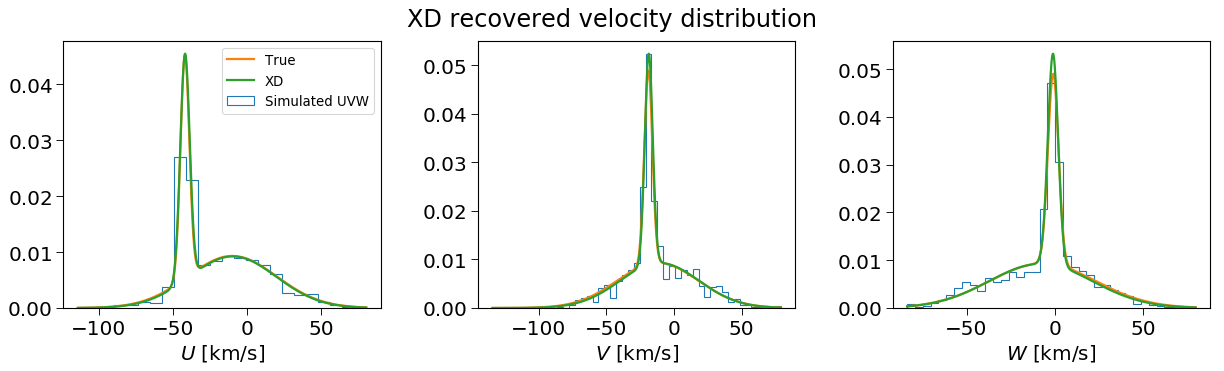

In [8]:
# Transform the simulated positions and velocities into astrometric observables and radial velocity in ICRS
galtoicrs = CoordinateTransformation(Transformations.GAL2ICRS)
x_icrs, y_icrs, z_icrs = galtoicrs.transformCartesianCoordinates(x_gal, y_gal, z_gal)
u_icrs, v_icrs, w_icrs = galtoicrs.transformCartesianCoordinates(uvw_gal[:,0], uvw_gal[:,1], uvw_gal[:,2])
alpha, delta, parallax, mura, mudec, vrad = phaseSpaceToAstrometry(x_icrs, y_icrs, z_icrs, u_icrs, v_icrs, w_icrs)

# The input to XD are the values of v_alpha*, v_delta, vrad. The other input required is the projection matrix.
# The values of v_alpha*, v_delta, vrad are obtained from (alpha, delta, parallax, mura,  mudec, vrad).

# Transformation from ICRS to Galactic coordinate systems
icrstogal = CoordinateTransformation(Transformations.ICRS2GAL)

# Calculate the projection matrix analogous to equation (1) in Bovy et al 2009 
# (https://ui.adsabs.harvard.edu/#abs/2009ApJ...700.1794B/abstract). Note the different ordering of the
# velocity components.
projection_matrices = np.zeros((Nstars,3,3))
for i in range(Nstars):
    pqr = np.array(normalTriad(alpha[i], delta[i])).T
    projection_matrices[i,:,:] = inv(np.dot(icrstogal.rotationMatrix, pqr))
    
# Calculate v_alpha*, v_delta
valpha = mura*constants.auKmYearPerSec/parallax
vdelta = mudec*constants.auKmYearPerSec/parallax

# Now do the deconvolution
initamp = np.ones(ncomponents)/float(ncomponents)

initmean = np.zeros((ncomponents, 3))
initmean[:,0] = uniform.rvs(loc=u_icrs.min(), scale=u_icrs.max(), size=ncomponents)
initmean[:,1] = uniform.rvs(loc=v_icrs.min(), scale=v_icrs.max(), size=ncomponents)
initmean[:,2] = uniform.rvs(loc=w_icrs.min(), scale=w_icrs.max(), size=ncomponents)

initcovar = np.zeros((ncomponents,3,3))
initcovar[:,0,0] = np.var(u_icrs)  
initcovar[:,1,1] = np.var(v_icrs)  
initcovar[:,2,2] = np.var(w_icrs)

warr = np.array([valpha, vdelta, vrad]).T
wcovar = np.zeros((Nstars,3,3))
logL = xd(warr, wcovar, initamp, initmean, initcovar, projection=projection_matrices)

amps_xd = initamp
means_xd = initmean
covs_xd = initcovar
print(amps_xd)
print(means_xd)
print(covs_xd)

fig = plt.figure(figsize=(16,5))
axA = fig.add_subplot(1,3,1)
axA.hist(uvw_gal[:,0], bins='auto', histtype='step', normed=True, label="Simulated UVW")
x = np.linspace(uvw_gal[:,0].min(), uvw_gal[:,0].max(), 1000)
axA.plot(x, amps_true[0]*norm.pdf(x, loc=means_componentA[0], scale=np.sqrt(covars_componentA[0,0])) +
        amps_true[1]*norm.pdf(x, loc=means_componentB[0], scale=np.sqrt(covars_componentB[0,0])), label="True")
axA.plot(x, amps_xd[0]*norm.pdf(x, loc=means_xd[0,0], scale=np.sqrt(covs_xd[0,0,0])) +
        amps_xd[1]*norm.pdf(x, loc=means_xd[1,0], scale=np.sqrt(covs_xd[1,0,0])), label="XD")
axA.set_xlabel('$U$ [km/s]')
axA.legend(fontsize=12)

axB = fig.add_subplot(1,3,2)
axB.hist(uvw_gal[:,1], bins='auto', histtype='step', normed=True)
x = np.linspace(uvw_gal[:,1].min(), uvw_gal[:,1].max(), 1000)
axB.plot(x, amps_true[0]*norm.pdf(x, loc=means_componentA[1], scale=np.sqrt(covars_componentA[1,1])) +
        amps_true[1]*norm.pdf(x, loc=means_componentB[1], scale=np.sqrt(covars_componentB[1,1])) )
axB.plot(x, amps_xd[0]*norm.pdf(x, loc=means_xd[0,1], scale=np.sqrt(covs_xd[0,1,1])) +
        amps_xd[1]*norm.pdf(x, loc=means_xd[1,1], scale=np.sqrt(covs_xd[1,1,1])) )
axB.set_xlabel('$V$ [km/s]')

axC = fig.add_subplot(1,3,3)
axC.hist(uvw_gal[:,2], bins='auto', histtype='step', normed=True)
x = np.linspace(uvw_gal[:,2].min(), uvw_gal[:,2].max(), 1000)
axC.plot(x, amps_true[0]*norm.pdf(x, loc=means_componentA[2], scale=np.sqrt(covars_componentA[2,2])) +
        amps_true[1]*norm.pdf(x, loc=means_componentB[2], scale=np.sqrt(covars_componentB[2,2])) )
axC.plot(x, amps_xd[0]*norm.pdf(x, loc=means_xd[0,2], scale=np.sqrt(covs_xd[0,2,2])) +
        amps_xd[1]*norm.pdf(x, loc=means_xd[1,2], scale=np.sqrt(covs_xd[1,2,2])) )
axC.set_xlabel('$W$ [km/s]')

plt.suptitle("XD recovered velocity distribution")
plt.tight_layout(pad=1.8)

plt.show()